In [1]:
pip install qiskit qiskit-machine-learning qiskit-aer pylatexenc

In [2]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from mpl_toolkits.mplot3d import Axes3D
from IPython.display import clear_output
from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.circuit.library import RealAmplitudes, ZZFeatureMap
from qiskit_algorithms.optimizers import COBYLA, L_BFGS_B
from qiskit_algorithms.utils import algorithm_globals

from qiskit_machine_learning.algorithms.classifiers import NeuralNetworkClassifier, VQC
from qiskit_machine_learning.algorithms.regressors import NeuralNetworkRegressor, VQR
from qiskit_machine_learning.neural_networks import SamplerQNN, EstimatorQNN
from qiskit_machine_learning.circuit.library import QNNCircuit
from qiskit.primitives import Sampler
from qiskit_algorithms.state_fidelities import ComputeUncompute
from qiskit_machine_learning.kernels import FidelityQuantumKernel

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

algorithm_globals.random_seed = 42

In [3]:
def generate_spatiotemporal_data(num_samples=100, dimension=2, random_seed=42):
    """
    Generate random spatiotemporal data in 2D or 3D space with autocorrelation.
    The time series will be treated as the index, not as part of the spatial dimensions.

    :param num_samples: Number of samples to generate
    :param dimension: Dimension of the spatial data (2D or 3D)
    :param random_seed: Seed for random number generation
    :return: Spatiotemporal data (X) and continuous labels (y), with time as index
    """
    np.random.seed(random_seed)

    # Generate random noise to add to the wave patterns
    random_noise = np.random.normal(0, 0.1, num_samples)  # Small noise

    time_series = np.linspace(0, 2 * np.pi, num_samples)  # Time points

    if dimension == 2:
        # Create random sinusoidal and cosine patterns with noise
        spatial_data_x = np.sin(time_series + random_noise)  # x-coordinates (wave pattern with noise)
        spatial_data_y = np.cos(time_series + random_noise)  # y-coordinates (wave pattern with noise)
        data = np.vstack([spatial_data_x, spatial_data_y]).T  # Combine spatial features (2D)
        columns = ['spatial_x', 'spatial_y']
    elif dimension == 3:
        # Create random sinusoidal and cosine patterns with noise for 3D
        spatial_data_x = np.sin(time_series + random_noise)  # x-coordinates (wave pattern with noise)
        spatial_data_y = np.cos(time_series + random_noise)  # y-coordinates (wave pattern with noise)
        spatial_data_z = np.sin(2 * time_series + random_noise)  # z-coordinates for 3D with noise
        data = np.vstack([spatial_data_x, spatial_data_y, spatial_data_z]).T  # Combine features for 3D space
        columns = ['spatial_x', 'spatial_y', 'spatial_z']

    # Generate continuous labels as a noisy sine wave for regression
    labels = np.array([1 if np.sin(t + random_noise[i]) > 0 else 0 for i, t in enumerate(time_series)])

    # Create a DataFrame with time as the index
    df = pd.DataFrame(data, columns=columns, index=time_series)

    return df, labels

In [4]:
# Step 6a: Visualization function for 2D spatiotemporal data
def visualize_spatiotemporal_data_2d(df, labels):
    """
    Visualize 2D spatiotemporal data from a DataFrame.
    :param df: DataFrame containing 2D spatial data (spatial_x, spatial_y) with time as the index
    :param labels: Binary labels
    """
    plt.scatter(df['spatial_x'], df['spatial_y'], c=labels, cmap='viridis')
    plt.xlabel('X Spatial')
    plt.ylabel('Y Spatial')
    plt.title('2D Spatiotemporal Data')
    plt.show()


# Step 6b: Visualization function for 3D spatiotemporal data
def visualize_spatiotemporal_data_3d(df, labels):
    """
    Visualize 3D spatiotemporal data from a DataFrame.
    :param df: DataFrame containing 3D spatial data (spatial_x, spatial_y, spatial_z) with time as the index
    :param labels: Binary labels
    """
    fig = plt.figure()
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(df['spatial_x'], df['spatial_y'], df['spatial_z'], c=labels, cmap='viridis')
    ax.set_xlabel('X Spatial')
    ax.set_ylabel('Y Spatial')
    ax.set_zlabel('Z Spatial')
    plt.title('3D Spatiotemporal Data')
    plt.show()

In [5]:
dimension = 3

In [6]:
# Generate 2D or 3D spatiotemporal data
data, labels = generate_spatiotemporal_data(num_samples=100, dimension=dimension)

In [7]:
scaler = StandardScaler()
scaled = scaler.fit_transform(data)

In [8]:
# Split into training and test sets
X_train, X_test, y_train, y_test = train_test_split(scaled, labels, test_size=0.2)

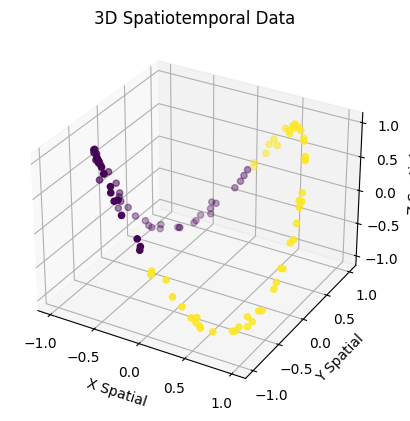

In [9]:
visualize_spatiotemporal_data_3d(data, labels)

In [10]:
qc = QNNCircuit(num_qubits=dimension)
qc.draw()

┌───────────────────────────────┐»
q_0: ┤0                              ├»
     │                               │»
q_1: ┤1 ZZFeatureMap(x[0],x[1],x[2]) ├»
     │                               │»
q_2: ┤2                              ├»
     └───────────────────────────────┘»
«     ┌────────────────────────────────────────────────────────────────────────────────┐
«q_0: ┤0                                                                               ├
«     │                                                                                │
«q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5],θ[6],θ[7],θ[8],θ[9],θ[10],θ[11]) ├
«     │                                                                                │
«q_2: ┤2                                                                               ├
«     └────────────────────────────────────────────────────────────────────────────────┘

In [11]:
estimator_qnn = EstimatorQNN(circuit=qc)
estimator_qnn.forward(X_train, algorithm_globals.random.random(estimator_qnn.num_weights))

array([[-0.38166392],
       [ 0.65200587],
       [ 0.13751906],
       [ 0.02056715],
       [ 0.47647107],
       [ 0.19189824],
       [ 0.42552096],
       [ 0.14006348],
       [ 0.00999075],
       [ 0.15807757],
       [ 0.620976  ],
       [ 0.65341475],
       [ 0.81426111],
       [ 0.50101675],
       [ 0.2005737 ],
       [ 0.3871976 ],
       [-0.44090758],
       [ 0.65189824],
       [-0.027691  ],
       [ 0.00126781],
       [ 0.49435925],
       [-0.02478296],
       [ 0.36088117],
       [ 0.35681363],
       [ 0.56111705],
       [ 0.24536221],
       [-0.56031364],
       [ 0.15874595],
       [ 0.43395573],
       [ 0.38403002],
       [ 0.42154627],
       [ 0.30033962],
       [-0.42105452],
       [ 0.14203213],
       [ 0.66881926],
       [-0.03798957],
       [ 0.08261502],
       [-0.2083388 ],
       [-0.51066726],
       [-0.45712335],
       [-0.2746442 ],
       [-0.02624826],
       [-0.0411716 ],
       [ 0.01726303],
       [ 0.1489466 ],
       [-0

In [12]:
def callback_graph(weights, obj_func_eval):
    clear_output(wait=True)
    objective_func_vals.append(obj_func_eval)
    plt.title("Objective function value against iteration")
    plt.xlabel("Iteration")
    plt.ylabel("Objective function value")
    plt.plot(range(len(objective_func_vals)), objective_func_vals)
    plt.show()

In [13]:
estimator_classifier = NeuralNetworkClassifier(
    estimator_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

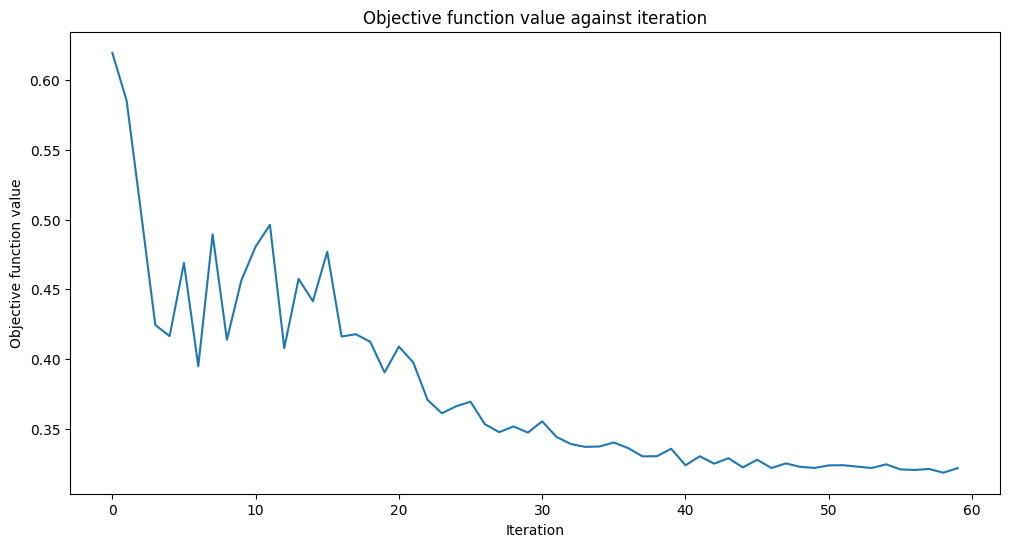

0.4

In [14]:
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
estimator_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
estimator_classifier.score(X_train, y_train)

In [15]:
estimator_classifier.score(X_test, y_test)

0.45

In [16]:
qc = QNNCircuit(ansatz=RealAmplitudes(dimension, reps=1))
qc.draw()

┌───────────────────────────────┐»
q_0: ┤0                              ├»
     │                               │»
q_1: ┤1 ZZFeatureMap(x[0],x[1],x[2]) ├»
     │                               │»
q_2: ┤2                              ├»
     └───────────────────────────────┘»
«     ┌────────────────────────────────────────────────┐
«q_0: ┤0                                               ├
«     │                                                │
«q_1: ┤1 RealAmplitudes(θ[0],θ[1],θ[2],θ[3],θ[4],θ[5]) ├
«     │                                                │
«q_2: ┤2                                               ├
«     └────────────────────────────────────────────────┘

In [17]:
# parity maps bitstrings to 0 or 1
def parity(x):
    return "{:b}".format(x).count("1") % 2


output_shape = 2

In [18]:
# construct QNN
sampler_qnn = SamplerQNN(
    circuit=qc,
    interpret=parity,
    output_shape=output_shape,
)

In [19]:
# construct classifier
sampler_classifier = NeuralNetworkClassifier(
    neural_network=sampler_qnn, optimizer=COBYLA(maxiter=60), callback=callback_graph
)

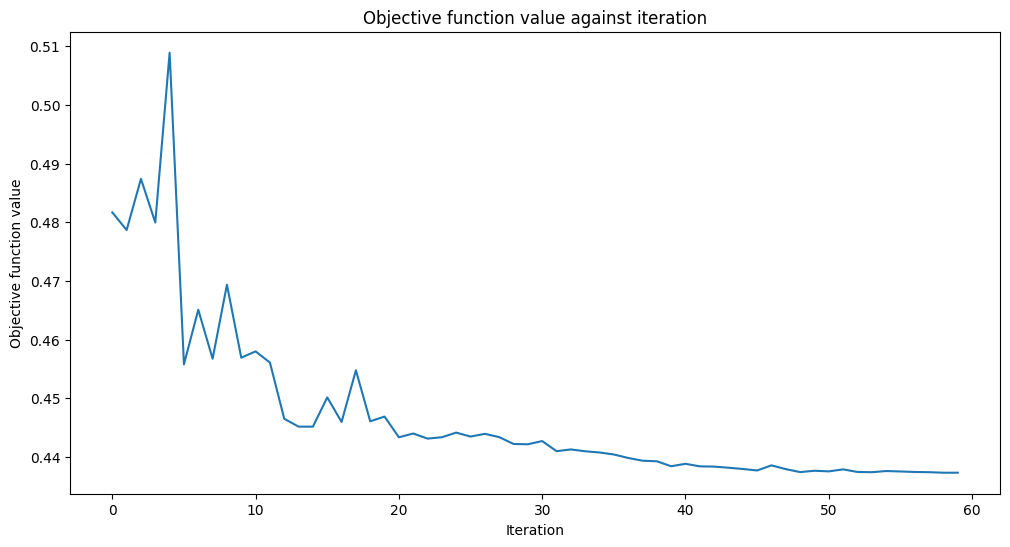

0.6875

In [20]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
sampler_classifier.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
sampler_classifier.score(X_train, y_train)

In [21]:
sampler_classifier.score(X_test, y_test)

0.8

In [22]:
# construct feature map, ansatz, and optimizer
feature_map = ZZFeatureMap(dimension)
ansatz = RealAmplitudes(dimension, reps=1)

# construct variational quantum classifier
vqc = VQC(
    feature_map=feature_map,
    ansatz=ansatz,
    loss="cross_entropy",
    optimizer=COBYLA(maxiter=60),
    callback=callback_graph,
)

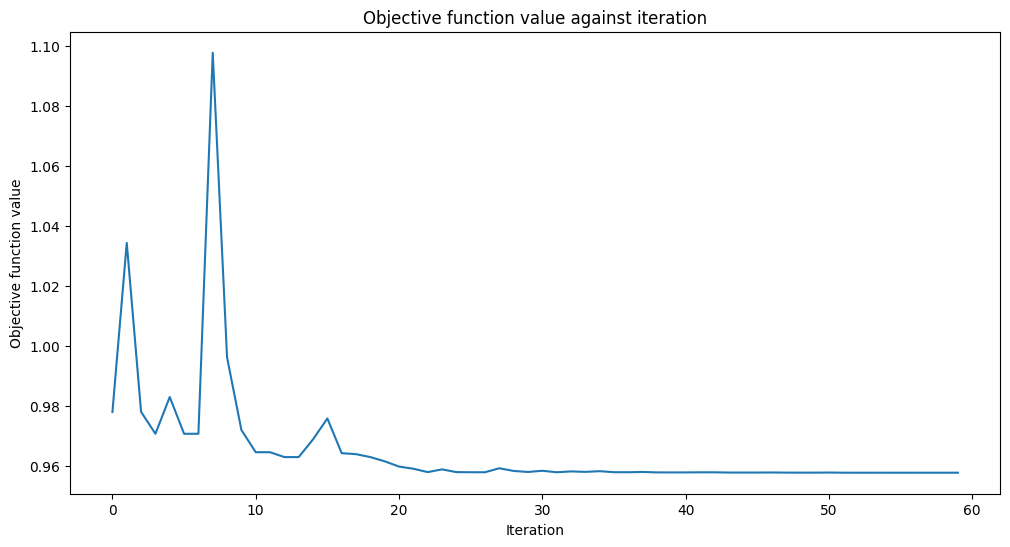

0.6

In [23]:
# create empty array for callback to store evaluations of the objective function
objective_func_vals = []
plt.rcParams["figure.figsize"] = (12, 6)

# fit classifier to data
vqc.fit(X_train, y_train)

# return to default figsize
plt.rcParams["figure.figsize"] = (6, 4)

# score classifier
vqc.score(X_train, y_train)

In [24]:
vqc.score(X_test, y_test)

0.5